In [262]:
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse import csr_matrix
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold

import os
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "..\config\credentials.json"
from tqdm import tqdm_notebook

In [188]:
%reload_ext google.cloud.bigquery

In [189]:
%%bigquery
SELECT
    COUNT(DISTINCT(unique_pid))
FROM
    playlist_songs.playlists;


,f0_
0,909100


In [190]:
%%bigquery
SELECT
    COUNT(unique_pid)
FROM
    playlist_songs.playlists;

,f0_
0,66346428


1. Get all tracks from random list of 1000 playlists. The limiting dimension is the playlist.
2. Train test split the data

In [193]:
%%bigquery playlist_tracks
SELECT
    ps.unique_pid, 
    ps.artist_name, 
    ps.track_name, 
    ps.album_name, 
    th.trackid,
    th.danceability,
    th.energy,
    th.key,
    th.loudness,
    th.mode,
    th.speechiness,
    th.acousticness,
    th.instrumentalness,
    th.liveness,
    th.valence,
    th.tempo,
    th.duration_ms,
    th.time_signature
FROM
    (SELECT 
        unique_pid
    FROM
        (SELECT
            unique_pid
        FROM
            playlist_songs.playlists
        GROUP BY
            unique_pid)
    WHERE
    RAND() < 500/909100 ) as ps_id
    INNER JOIN
    playlist_songs.playlists as ps
    ON ps_id.unique_pid = ps.unique_pid
    INNER JOIN
    playlist_songs.tracks_headers as th
    ON th.trackid = ps.track_uri;

In [194]:
playlist_tracks.head(1)

,unique_pid,artist_name,track_name,album_name,trackid,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
0,8169,Monstercat,Monstercat Best of 2012,Monstercat - Best of 2012,spotify:track:6jvMmRtSzoEibQGrQkSISQ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [195]:
playlist_analysis = playlist_tracks[['unique_pid', 'trackid','danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
            'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
            'duration_ms', 'time_signature']]

playlist_song_info = playlist_tracks[['trackid', 'artist_name', 'track_name', 'album_name']]

In [196]:
# (spread procedure - group by track and features one hot encode playlist assignments)
playlist_analysis.loc[:, 'one'] = 1
# playlist_one_hot = playlist_analysis.pivot(index='trackid', columns='', values='')
playlist_analysis = playlist_analysis.drop_duplicates(subset=['unique_pid', 'trackid'])
playlist_one_hot = playlist_analysis.pivot(index="trackid", columns='unique_pid', values="one")

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [197]:
playlist_one_hot = playlist_one_hot.fillna(value=0)

In [198]:
# get histogram of songs associated with # playlists
playlist_one_hot.loc[:, "sum"] = playlist_one_hot.sum(axis = 1)

In [199]:
playlist_one_hot.head()

unique_pid,1425,4989,5670,7898,8169,13928,21272,23464,26909,30138,...,982473,983483,988355,988357,989649,990810,991752,994377,999155,sum
trackid,,,,,,,,,,,,,,,,,,,,,
spotify:track:0003Z98F6hUq7XxqSRM87H,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
spotify:track:0004ExljAge0P5XWn1LXmW,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
spotify:track:000xQL6tZNLJzIrtIgxqSl,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0
spotify:track:0032P9X3AD4AQvN7yzpmTo,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
spotify:track:004skCQeDn1iLntSom0rRr,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [200]:
playlist_distribution = playlist_one_hot.groupby("sum")["sum"].count()


In [201]:
playlist_distribution

sum
1.0     16243
2.0      2349
3.0       882
4.0       441
5.0       290
6.0       172
7.0       141
8.0       106
9.0        57
10.0       48
11.0       33
12.0       33
13.0       21
14.0       13
15.0       11
16.0        7
17.0        5
18.0        2
19.0        2
20.0        3
21.0        2
22.0        1
24.0        1
25.0        2
27.0        1
Name: sum, dtype: int64

In [202]:
# get all playlist numbers
playlist_numbers = [i for i in playlist_one_hot.columns if i not in ['trackid', 'sum']]
# merge features with one-hot list
playlist_features = playlist_analysis[['trackid','danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
            'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
            'duration_ms', 'time_signature']]
playlist_one_hot = playlist_one_hot.drop("sum", axis = 1)

In [203]:
playlist_one_hot_w_features = playlist_one_hot.merge(playlist_features, on="trackid", how="inner")

In [232]:
y = playlist_one_hot_w_features[playlist_numbers]
X = playlist_one_hot_w_features[['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
            'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
            'duration_ms', 'time_signature']]

print(X.shape)
print(y.shape)
X = X.fillna(-1) #if na then fill with -1

(32536, 13)
(32536, 480)


In [233]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

Now train model using k-nearest neighbors mahalanobis distance for one model and then extend to multiple models

In [243]:
#create mask for smaller X_train data

mask = np.random.choice([False, True], len(X_train), p=[0.75, 0.25])
X_train_compressed = X_train[mask][:]
X_train_compressed.shape
y_train_compressed = y_train[mask][:]
y_train_compressed.shape

(6449, 480)

In [ ]:
ks = [2, 5, 7, 10]
output = []
playlists = range(0, len(playlist_numbers))

total_loops = len(playlists) * len(ks)
with tqdm_notebook(total=total_loops) as pbar:
    for playlist in playlists:
        for k in ks:
            # https://towardsdatascience.com/building-a-k-nearest-neighbors-k-nn-model-with-scikit-learn-51209555453a
#             print(f'''**************************************'''
#                   f'''\nRunning kNN classification for k={k}''')
            knn_cv = KNeighborsClassifier(n_neighbors=k, metric='euclidean')
            cv_scores = cross_val_score(knn_cv, X_train, y_train[:, playlist], cv=5)
            output.append({"k": k, "cv_scores_mean": np.mean(cv_scores), "playlist": playlist})
#             print(f'''cv_scores: {cv_scores}''')
#             print(f'''cv_scores mean: {np.mean(cv_scores)}''')
            pbar.update(1)



plot of mean cv scores for k=2 for multiple play lists


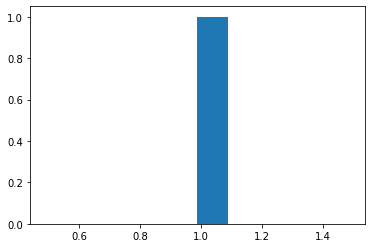

plot of mean cv scores for k=5 for multiple play lists


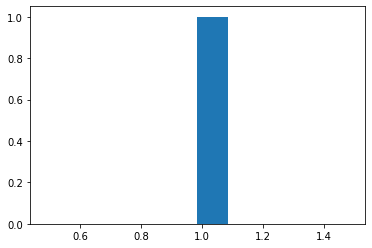

plot of mean cv scores for k=7 for multiple play lists


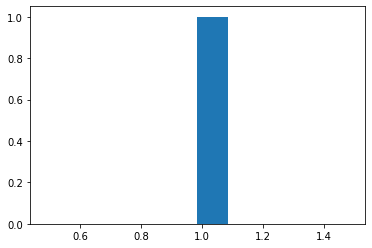

plot of mean cv scores for k=10 for multiple play lists


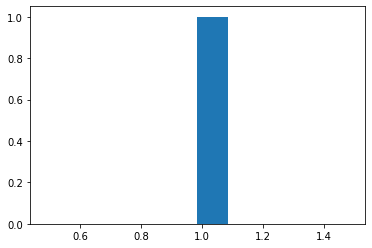

In [259]:
output = pd.DataFrame(output)
for k in ks:
    print(f"plot of mean cv scores for k={k} for multiple play lists")
    subset = output.loc[output.k==k,:]
    plt.hist(subset["cv_scores_mean"])
    plt.show()
